In [1]:
import pandas as pd
import numpy as np

sampled_data = pd.read_parquet("sampled_simulations_5th.parquet")

In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Add normalized time to the features
def normalize_time_per_simulation(df, simulation_column, time_column):
    # Normalize time for each simulation
    df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
    return df

# Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Update features (X) to include normalized time
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes'])


Y = sampled_data[['5nm_retentate', '5nm_permeate',
                  '40nm_retentate', '40nm_permeate', 
                  '70nm_retentate', '70nm_permeate',   
                  '120nm_retentate', '120nm_permeate',  
                  '190nm_retentate', '190nm_permeate', 
                  '300nm_retentate', '300nm_permeate', 
                  '700nm_retentate', '700nm_permeate', 
                  '2500nm_retentate', '2500nm_permeate',
                  'Diavolumes']]
# Add normalized time to the features

groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 6

# Split data into train-validation and test sets
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X, Y, groups))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5  # Use optimal number of splits from previous step
group_kfold = GroupKFold(n_splits=n_folds)# Range of components to test
component_range = range(1, 11)  # Test 1 to 10 components

print("PLS Components Validation Results:")
print("-" * 50)

for n_components in component_range:
    # Initialize cross-validation metrics
    validation_q2_list, validation_r2_list = [], []
    validation_mae_list, validation_mse_list, validation_rmse_list = [], [], []

    # 5-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
        # Split data
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

        # Scale data
        X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = feature_scaler.transform(X_val_fold)

        # Train PLS model with current number of components
        pls_model = PLSRegression(n_components=n_components)
        pls_model.fit(X_train_fold_scaled, Y_train_fold)

        # Predict on validation set
        Y_val_pred = pls_model.predict(X_val_fold_scaled)

        # Compute metrics for validation set
        val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
        val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_q2 = np.mean(1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                              np.sum((Y_val_fold - Y_val_fold.mean(axis=0)) ** 2, axis=0)))  # Q²

        # Store metrics for this fold
        validation_q2_list.append(val_q2)
        validation_r2_list.append(val_r2)
        validation_mae_list.append(np.mean(val_mae))
        validation_mse_list.append(np.mean(val_mse))
        validation_rmse_list.append(np.mean(val_rmse))

    # Average metrics across folds for this number of components
    avg_val_q2 = np.mean(validation_q2_list)
    avg_val_r2 = np.mean(validation_r2_list)
    avg_val_mae = np.mean(validation_mae_list)
    avg_val_mse = np.mean(validation_mse_list)
    avg_val_rmse = np.mean(validation_rmse_list)

    # Print results for this number of components
    print(f"Number of Components: {n_components}")
    print(f"  Q²: {avg_val_q2:.4f}")
    print(f"  R²: {avg_val_r2:.4f}")
    print(f"  MAE: {avg_val_mae:.4f}")
    print(f"  MSE: {avg_val_mse:.4f}")
    print(f"  RMSE: {avg_val_rmse:.4f}")
    print("-" * 50)


PLS Components Validation Results:
--------------------------------------------------
Number of Components: 1
  Q²: 0.4650
  R²: 0.4965
  MAE: 0.0333
  MSE: 0.0297
  RMSE: 0.0419
--------------------------------------------------
Number of Components: 2
  Q²: 0.5379
  R²: 0.5651
  MAE: 0.0332
  MSE: 0.0294
  RMSE: 0.0417
--------------------------------------------------
Number of Components: 3
  Q²: 0.6653
  R²: 0.6850
  MAE: 0.0207
  MSE: 0.0152
  RMSE: 0.0300
--------------------------------------------------
Number of Components: 4
  Q²: 0.6881
  R²: 0.7064
  MAE: 0.0206
  MSE: 0.0152
  RMSE: 0.0300
--------------------------------------------------
Number of Components: 5
  Q²: 0.7067
  R²: 0.7239
  MAE: 0.0205
  MSE: 0.0124
  RMSE: 0.0271
--------------------------------------------------
Number of Components: 6
  Q²: 0.7123
  R²: 0.7293
  MAE: 0.0203
  MSE: 0.0120
  RMSE: 0.0267
--------------------------------------------------
Number of Components: 7
  Q²: 0.7165
  R²: 0.7332


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Example data preparation (replace with your actual data)
# sampled_data = pd.read_csv('your_data.csv')  # Load your dataset
# X = sampled_data.drop(columns=[...])  # Define features
# Y = sampled_data[['target1', 'target2', ...]]  # Define targets
# groups = sampled_data['Simulation_ID']  # Define groups for GroupKFold

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
#     # Normalize time for each simulation
#     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
#     return df

# # Apply the function to normalize time
# sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# # Update features (X) to include normalized time
# X = sampled_data.drop(columns=['Simulation_ID',  'Time (s)',
#                                '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
#                                '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
#                                '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
#                                '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
#                                '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
#                                '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
#                                '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
#                                '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
#                                'Diavolumes'])


# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]
# # Add normalized time to the features

# groups = sampled_data['Simulation_ID']

# # Define the number of components for PLS


# # Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# # Define the number of trees and other hyperparameters for Random Forest
 

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X, Y, groups))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)
# Define the number of trees and depths to test
n_estimators_list = [10, 20, 30, 40, 50,60,70,80,90,100]
max_depth_list = [5, 10, 15, 20, 30]  # None means no limit

# Initialize a DataFrame to store results
results = []



# Loop over different numbers of trees and depths
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        print(f"Testing n_estimators={n_estimators}, max_depth={max_depth}")

        # Initialize placeholders for aggregate metrics
        validation_q2_list, validation_r2_list = [], []
        validation_mae_list, validation_mse_list, validation_rmse_list = [], [], []

        # Cross-validation loop
        for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
            # Split data
            X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

            # Train the model
            rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            rf_model.fit(X_train_fold, Y_train_fold)

            # Predict on validation set
            Y_val_pred = rf_model.predict(X_val_fold)

            # Compute metrics for validation set
            val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
            val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')

            # Correct calculation of Q²
            train_mean = Y_train_fold.mean(axis=0)  # Mean of the training set
            val_q2 = 1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                          np.sum((Y_val_fold - train_mean) ** 2, axis=0))
            val_q2 = np.mean(val_q2)  # Average Q² across all targets

            # Aggregate metrics across folds
            validation_q2_list.append(val_q2)
            validation_r2_list.append(val_r2)
            validation_mae_list.append(np.mean(val_mae))
            validation_mse_list.append(np.mean(val_mse))
            validation_rmse_list.append(np.mean(val_rmse))
            

        # Compute averages across all folds for validation
        avg_val_q2 = np.mean(validation_q2_list)
        avg_val_r2 = np.mean(validation_r2_list)
        avg_val_mae = np.mean(validation_mae_list)
        avg_val_mse = np.mean(validation_mse_list)
        avg_val_rmse = np.mean(validation_rmse_list)
        print(f"  Q²: {avg_val_q2:.7f}")
        print(f"  R²: {avg_val_r2:.7f}")
        print(f"  MAE: {avg_val_mae:.7f}")
        print(f"  MSE: {avg_val_mse:.7f}")
        print(f"  RMSE: {avg_val_rmse:.7f}")
        # Store results
        results.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'avg_val_q2': avg_val_q2,
            'avg_val_r2': avg_val_r2,
            'avg_val_mae': avg_val_mae,
            'avg_val_mse': avg_val_mse,
            'avg_val_rmse': avg_val_rmse
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("\nValidation Results for Different Hyperparameters:")
print(results_df)

# Save results to a CSV file
results_df.to_csv('random_forest_hyperparameter_tuning_results.csv', index=False)

Testing n_estimators=10, max_depth=5
  Q²: 0.4967724
  R²: 0.5260527
  MAE: 0.0105206
  MSE: 0.0057885
  RMSE: 0.0186259
Testing n_estimators=10, max_depth=10
  Q²: 0.6866768
  R²: 0.7048915
  MAE: 0.0061088
  MSE: 0.0030131
  RMSE: 0.0134405
Testing n_estimators=10, max_depth=15
  Q²: 0.8707078
  R²: 0.8781978
  MAE: 0.0041254
  MSE: 0.0022460
  RMSE: 0.0115412
Testing n_estimators=10, max_depth=20
  Q²: 0.9083517
  R²: 0.9136850
  MAE: 0.0036695
  MSE: 0.0022452
  RMSE: 0.0115283
Testing n_estimators=10, max_depth=30
  Q²: 0.9139331
  R²: 0.9189415
  MAE: 0.0036257
  MSE: 0.0022628
  RMSE: 0.0115710
Testing n_estimators=20, max_depth=5
  Q²: 0.4968068
  R²: 0.5260851
  MAE: 0.0105149
  MSE: 0.0057831
  RMSE: 0.0186172
Testing n_estimators=20, max_depth=10
  Q²: 0.6868459
  R²: 0.7050508
  MAE: 0.0060962
  MSE: 0.0030103
  RMSE: 0.0134348
Testing n_estimators=20, max_depth=15
  Q²: 0.8716251
  R²: 0.8790619
  MAE: 0.0041000
  MSE: 0.0022087
  RMSE: 0.0114449
Testing n_estimators=20, m

In [5]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


X_log= np.log1p(X)
# Define the number of components for PLS


# Split data into train-validation and test sets

train_val_idx, test_idx = next(group_split.split(X_log, Y, groups))

X_train_val, X_test = X_log.iloc[train_val_idx], X_log.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5  # Use optimal number of splits from previous step
group_kfold = GroupKFold(n_splits=n_folds)# Range of components to test
component_range = range(1, 11)  # Test 1 to 10 components

print("PLS Components Validation Results:")
print("-" * 50)

for n_components in component_range:
    # Initialize cross-validation metrics
    validation_q2_list, validation_r2_list = [], []
    validation_mae_list, validation_mse_list, validation_rmse_list = [], [], []

    # 5-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
        # Split data
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

        # Scale data
        X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = feature_scaler.transform(X_val_fold)

        # Train PLS model with current number of components
        pls_model_logx = PLSRegression(n_components=n_components)
        pls_model_logx.fit(X_train_fold_scaled, Y_train_fold)

        # Predict on validation set
        Y_val_pred = pls_model_logx.predict(X_val_fold_scaled)

        # Compute metrics for validation set
        val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
        val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_q2 = np.mean(1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                              np.sum((Y_val_fold - Y_val_fold.mean(axis=0)) ** 2, axis=0)))  # Q²

        # Store metrics for this fold
        validation_q2_list.append(val_q2)
        validation_r2_list.append(val_r2)
        validation_mae_list.append(np.mean(val_mae))
        validation_mse_list.append(np.mean(val_mse))
        validation_rmse_list.append(np.mean(val_rmse))

    # Average metrics across folds for this number of components
    avg_val_q2 = np.mean(validation_q2_list)
    avg_val_r2 = np.mean(validation_r2_list)
    avg_val_mae = np.mean(validation_mae_list)
    avg_val_mse = np.mean(validation_mse_list)
    avg_val_rmse = np.mean(validation_rmse_list)

    # Print results for this number of components
    print(f"Number of Components: {n_components}")
    print(f"  Q²: {avg_val_q2:.4f}")
    print(f"  R²: {avg_val_r2:.4f}")
    print(f"  MAE: {avg_val_mae:.4f}")
    print(f"  MSE: {avg_val_mse:.4f}")
    print(f"  RMSE: {avg_val_rmse:.4f}")
    print("-" * 50)


PLS Components Validation Results:
--------------------------------------------------
Number of Components: 1
  Q²: 0.4153
  R²: 0.4497
  MAE: 0.0328
  MSE: 0.0290
  RMSE: 0.0414
--------------------------------------------------
Number of Components: 2
  Q²: 0.5247
  R²: 0.5526
  MAE: 0.0328
  MSE: 0.0289
  RMSE: 0.0413
--------------------------------------------------
Number of Components: 3
  Q²: 0.6703
  R²: 0.6897
  MAE: 0.0188
  MSE: 0.0116
  RMSE: 0.0262
--------------------------------------------------
Number of Components: 4
  Q²: 0.6870
  R²: 0.7054
  MAE: 0.0188
  MSE: 0.0116
  RMSE: 0.0262
--------------------------------------------------
Number of Components: 5
  Q²: 0.6990
  R²: 0.7167
  MAE: 0.0184
  MSE: 0.0100
  RMSE: 0.0244
--------------------------------------------------
Number of Components: 6
  Q²: 0.7032
  R²: 0.7206
  MAE: 0.0183
  MSE: 0.0100
  RMSE: 0.0244
--------------------------------------------------
Number of Components: 7
  Q²: 0.7068
  R²: 0.7241


In [6]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


X_exp= np.exp(X)
# Define the number of components for PLS


# Split data into train-validation and test sets

train_val_idx, test_idx = next(group_split.split(X_exp, Y, groups))

X_train_val, X_test = X_exp.iloc[train_val_idx], X_exp.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5  # Use optimal number of splits from previous step
group_kfold = GroupKFold(n_splits=n_folds)# Range of components to test
component_range = range(1, 11)  # Test 1 to 10 components

print("PLS Components Validation Results:")
print("-" * 50)

for n_components in component_range:
    # Initialize cross-validation metrics
    validation_q2_list, validation_r2_list = [], []
    validation_mae_list, validation_mse_list, validation_rmse_list = [], [], []

    # 5-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
        # Split data
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

        # Scale data
        X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = feature_scaler.transform(X_val_fold)

        # Train PLS model with current number of components
        pls_model_exp = PLSRegression(n_components=n_components)
        pls_model_exp.fit(X_train_fold_scaled, Y_train_fold)

        # Predict on validation set
        Y_val_pred = pls_model_exp.predict(X_val_fold_scaled)

        # Compute metrics for validation set
        val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
        val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_q2 = np.mean(1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                              np.sum((Y_val_fold - Y_val_fold.mean(axis=0)) ** 2, axis=0)))  # Q²

        # Store metrics for this fold
        validation_q2_list.append(val_q2)
        validation_r2_list.append(val_r2)
        validation_mae_list.append(np.mean(val_mae))
        validation_mse_list.append(np.mean(val_mse))
        validation_rmse_list.append(np.mean(val_rmse))

    # Average metrics across folds for this number of components
    avg_val_q2 = np.mean(validation_q2_list)
    avg_val_r2 = np.mean(validation_r2_list)
    avg_val_mae = np.mean(validation_mae_list)
    avg_val_mse = np.mean(validation_mse_list)
    avg_val_rmse = np.mean(validation_rmse_list)

    # Print results for this number of components
    print(f"Number of Components: {n_components}")
    print(f"  Q²: {avg_val_q2:.4f}")
    print(f"  R²: {avg_val_r2:.4f}")
    print(f"  MAE: {avg_val_mae:.4f}")
    print(f"  MSE: {avg_val_mse:.4f}")
    print(f"  RMSE: {avg_val_rmse:.4f}")
    print("-" * 50)


PLS Components Validation Results:
--------------------------------------------------
Number of Components: 1
  Q²: 0.2756
  R²: 0.3182
  MAE: 0.0334
  MSE: 0.0296
  RMSE: 0.0419
--------------------------------------------------
Number of Components: 2
  Q²: 0.3428
  R²: 0.3815
  MAE: 0.0333
  MSE: 0.0294
  RMSE: 0.0417
--------------------------------------------------
Number of Components: 3
  Q²: 0.4538
  R²: 0.4859
  MAE: 0.0240
  MSE: 0.0186
  RMSE: 0.0332
--------------------------------------------------
Number of Components: 4
  Q²: 0.4876
  R²: 0.5177
  MAE: 0.0229
  MSE: 0.0178
  RMSE: 0.0325
--------------------------------------------------
Number of Components: 5
  Q²: 0.4936
  R²: 0.5234
  MAE: 0.0228
  MSE: 0.0177
  RMSE: 0.0324
--------------------------------------------------
Number of Components: 6
  Q²: 0.4975
  R²: 0.5270
  MAE: 0.0228
  MSE: 0.0177
  RMSE: 0.0324
--------------------------------------------------
Number of Components: 7
  Q²: 0.4996
  R²: 0.5290


In [8]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


X_sqrt= np.sqrt(X)
# Define the number of components for PLS


# Split data into train-validation and test sets

train_val_idx, test_idx = next(group_split.split(X_sqrt, Y, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5  # Use optimal number of splits from previous step
group_kfold = GroupKFold(n_splits=n_folds)# Range of components to test
component_range = range(1, 11)  # Test 1 to 10 components

print("PLS Components Validation Results:")
print("-" * 50)

for n_components in component_range:
    # Initialize cross-validation metrics
    validation_q2_list, validation_r2_list = [], []
    validation_mae_list, validation_mse_list, validation_rmse_list = [], [], []

    # 5-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
        # Split data
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

        # Scale data
        X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = feature_scaler.transform(X_val_fold)

        # Train PLS model with current number of components
        pls_model_sqrt = PLSRegression(n_components=n_components)
        pls_model_sqrt.fit(X_train_fold_scaled, Y_train_fold)

        # Predict on validation set
        Y_val_pred = pls_model_sqrt.predict(X_val_fold_scaled)

        # Compute metrics for validation set
        val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
        val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
        val_q2 = np.mean(1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                              np.sum((Y_val_fold - Y_val_fold.mean(axis=0)) ** 2, axis=0)))  # Q²

        # Store metrics for this fold
        validation_q2_list.append(val_q2)
        validation_r2_list.append(val_r2)
        validation_mae_list.append(np.mean(val_mae))
        validation_mse_list.append(np.mean(val_mse))
        validation_rmse_list.append(np.mean(val_rmse))

    # Average metrics across folds for this number of components
    avg_val_q2 = np.mean(validation_q2_list)
    avg_val_r2 = np.mean(validation_r2_list)
    avg_val_mae = np.mean(validation_mae_list)
    avg_val_mse = np.mean(validation_mse_list)
    avg_val_rmse = np.mean(validation_rmse_list)

    # Print results for this number of components
    print(f"Number of Components: {n_components}")
    print(f"  Q²: {avg_val_q2:.4f}")
    print(f"  R²: {avg_val_r2:.4f}")
    print(f"  MAE: {avg_val_mae:.4f}")
    print(f"  MSE: {avg_val_mse:.4f}")
    print(f"  RMSE: {avg_val_rmse:.4f}")
    print("-" * 50)


PLS Components Validation Results:
--------------------------------------------------
Number of Components: 1
  Q²: 0.4608
  R²: 0.4925
  MAE: 0.0330
  MSE: 0.0292
  RMSE: 0.0416
--------------------------------------------------
Number of Components: 2
  Q²: 0.5378
  R²: 0.5650
  MAE: 0.0326
  MSE: 0.0286
  RMSE: 0.0411
--------------------------------------------------
Number of Components: 3
  Q²: 0.6702
  R²: 0.6896
  MAE: 0.0202
  MSE: 0.0132
  RMSE: 0.0279
--------------------------------------------------
Number of Components: 4
  Q²: 0.6940
  R²: 0.7120
  MAE: 0.0202
  MSE: 0.0132
  RMSE: 0.0279
--------------------------------------------------
Number of Components: 5
  Q²: 0.7086
  R²: 0.7257
  MAE: 0.0195
  MSE: 0.0112
  RMSE: 0.0258
--------------------------------------------------
Number of Components: 6
  Q²: 0.7137
  R²: 0.7305
  MAE: 0.0194
  MSE: 0.0112
  RMSE: 0.0257
--------------------------------------------------
Number of Components: 7
  Q²: 0.7167
  R²: 0.7334


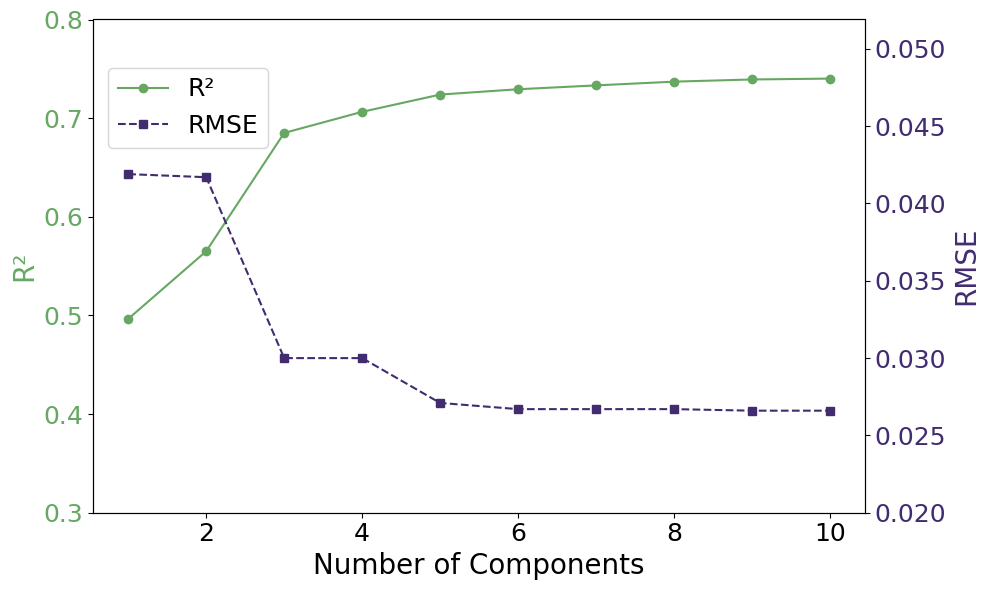

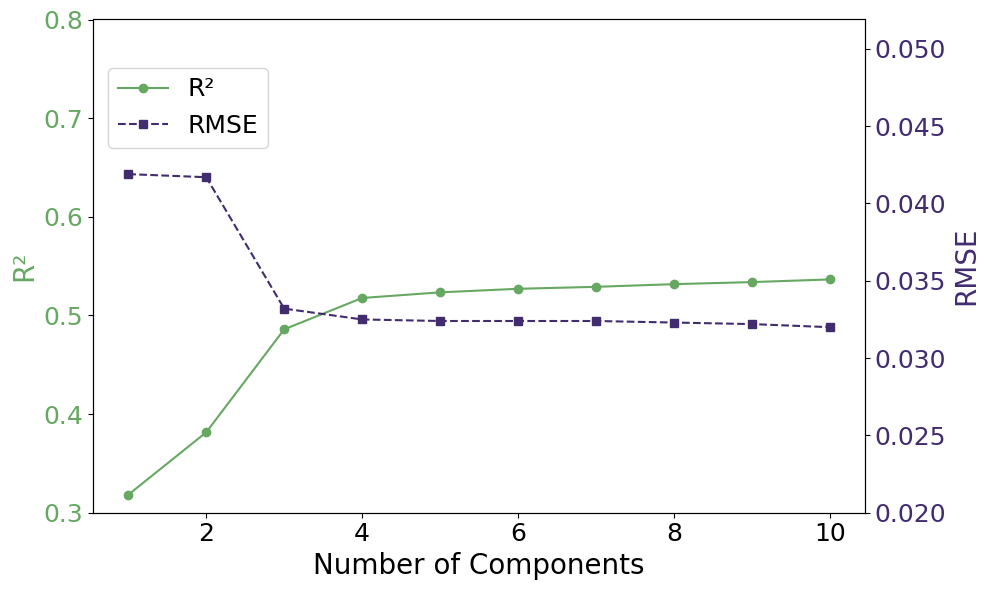

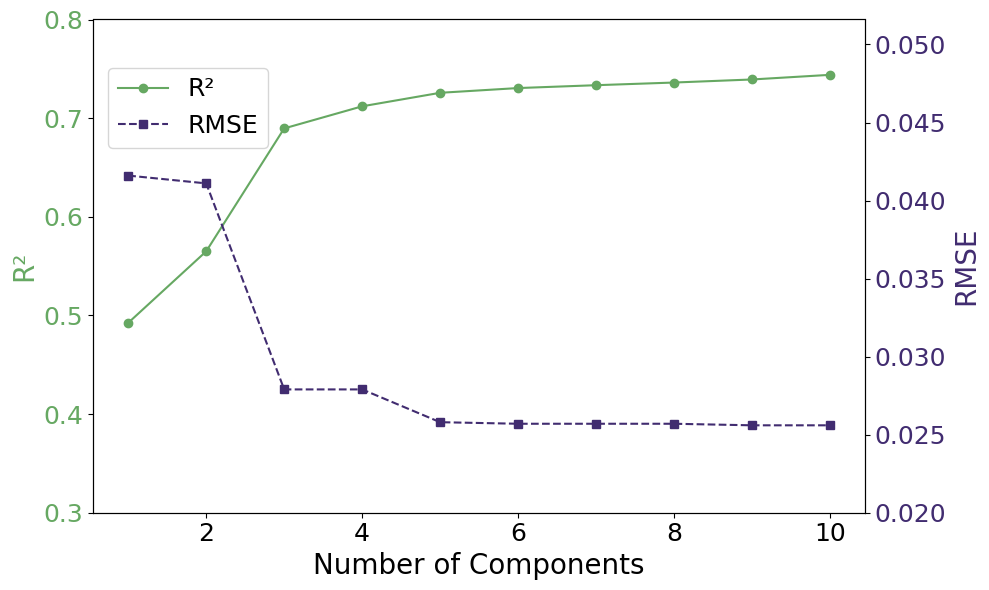

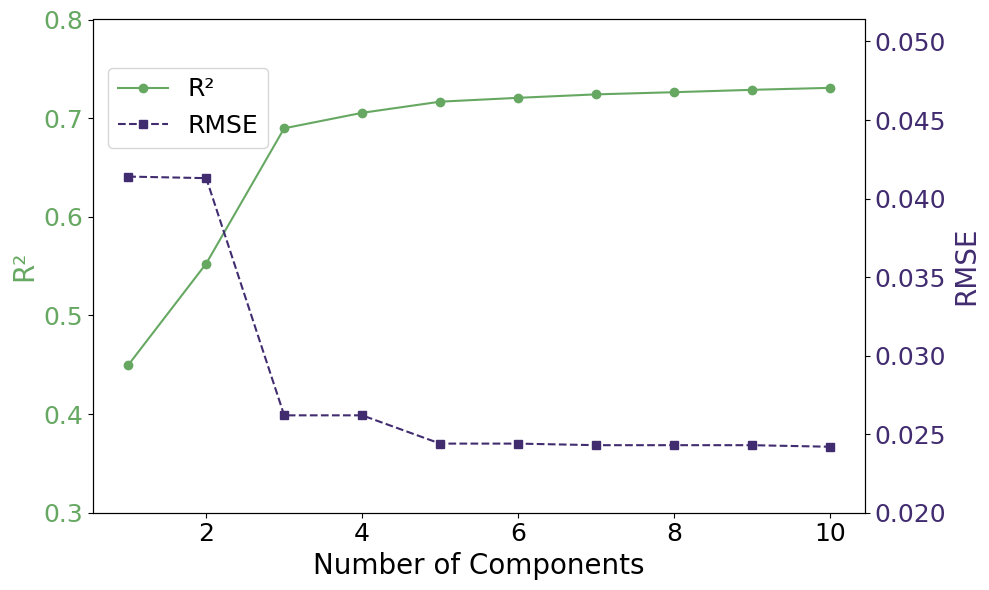

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each group
groups = {
    "No Feature Transformation": {
        "Components": np.arange(1, 11),
        "R2": [0.4965, 0.5651, 0.6850, 0.7064, 0.7239, 0.7293, 0.7332, 0.7370, 0.7392, 0.7401],
        "RMSE": [0.0419, 0.0417, 0.0300, 0.0300, 0.0271, 0.0267, 0.0267, 0.0267, 0.0266, 0.0266]
    },
    "EXP": {
        "Components": np.arange(1, 11),
        "R2": [0.3182, 0.3815, 0.4859, 0.5177, 0.5234, 0.5270, 0.5290, 0.5317, 0.5338, 0.5365],
        "RMSE": [0.0419, 0.0417, 0.0332, 0.0325, 0.0324, 0.0324, 0.0324, 0.0323, 0.0322, 0.0320]
    },
    "SQRT": {
        "Components": np.arange(1, 11),
        "R2": [0.4925, 0.5650, 0.6896, 0.7120, 0.7257, 0.7305, 0.7334, 0.7361, 0.7392, 0.7439],
        "RMSE": [0.0416, 0.0411, 0.0279, 0.0279, 0.0258, 0.0257, 0.0257, 0.0257, 0.0256, 0.0256]
    },"Log Values": {
        "Components": np.arange(1, 11),
        "R2": [0.4497, 0.5526, 0.6897, 0.7054, 0.7167, 0.7206, 0.7241, 0.7263, 0.7287, 0.7307],
        "RMSE": [0.0414, 0.0413, 0.0262, 0.0262, 0.0244, 0.0244, 0.0243, 0.0243, 0.0243, 0.0242]
    }
}


# Create a plot for each group
for group_name, data in groups.items():
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot R² on the first y-axis
    color = '#66a862'
    ax1.set_xlabel('Number of Components',fontsize = 20)
    ax1.set_ylabel('R²', color=color,fontsize = 20)
    ax1.plot(data['Components'], data['R2'], marker='o', linestyle='-', color=color, label='R²')
    ax1.tick_params(axis='y', labelcolor=color,labelsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.set_ylim(0.3, 0.8)  # R² ranges from 0 to 1
    
    # Create a second y-axis for RMSE
    ax2 = ax1.twinx()
    color = '#412C70'
    ax2.set_ylabel('RMSE', color=color,fontsize = 20)
    ax2.plot(data['Components'], data['RMSE'], marker='s', linestyle='--', color=color, label='RMSE')
    ax2.tick_params(axis='y', labelcolor=color,labelsize=18)
    ax2.set_ylim(0.02, max(data['RMSE']) + 0.01)  # Adjust RMSE y-axis limit
    
    # Add title and legend

    # plt.title(f'{group_name}: R² and RMSE vs Number of Components')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=18)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f'{group_name.replace(" ", "_")}_R2_RMSE_plot.png')
    plt.show()